Video Game Sales with Ratings https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings?resource=download

Metadata

Name Name of the game

Platform Console on which the game is running

Year_of_Release Year of the game released

Genre Game's category

Publisher Publisher

NA_Sales Game sales in North America (in millions of units)

EU_Sales Game sales in the European Union (in millions of units)

JP_Sales Game sales in Japan (in millions of units)

Other_Sales Game sales in the rest of the world, i.e. Africa, Asia excluding Japan, Australia, Europe excluding the E.U. and South America (in millions of units)

Global_Sales Total sales in the world (in millions of units)

Critic_Score The average critic review score (scale of 0-100, many missing values).

Critic_Count The number of critic reviews.

User_Score The average user review score (scale of 0-10, but stored as object, possibly due to non-numeric values).

User_Count The number of user reviews.

Developer The company that developed the game.

Rating The ESRB rating (e.g., E for everyone, E10+ for everyone 10 yrs old or above, T for Teen, M for mature).

In [47]:
print(data['Platform'].unique())


['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']


In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
data=pd.read_csv("/content/drive/My Drive/csv/1Video_Games_Sales_as_at_22_Dec_2016.csv")

In [56]:
#Make a copy to separate the
data_copy = data

In [57]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

# ------------------ Data Cleaning ------------------
required_columns = ['Platform', 'Year_of_Release', 'Publisher', 'Rating',
                    'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer']

data_copy = data.copy()
data_copy.dropna(subset=required_columns, inplace=True)
data_copy.drop(columns=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Name'], inplace=True)
data_copy.dropna(subset=['Global_Sales'], inplace=True)

# Convert User_Score
data_copy['User_Score'] = pd.to_numeric(data_copy['User_Score'], errors='coerce')
data_copy.dropna(subset=['User_Score'], inplace=True)

# Year of Release to int
data_copy['Year_of_Release'] = data_copy['Year_of_Release'].astype(int)

# ------------------ Noise Reduction ------------------
sales_cap = data_copy['Global_Sales'].quantile(0.99)
data_copy = data_copy[data_copy['Global_Sales'] <= sales_cap]



# ------------------ Feature Engineering ------------------

# Frequency encoding for Developer and Publisher
for col in ['Developer', 'Publisher']:
    freq_map = data_copy[col].value_counts().to_dict()
    data_copy[col + '_Freq'] = data_copy[col].map(freq_map)

# Label encoding for categorical columns
categorical_columns = ['Platform', 'Genre', 'Rating', 'Year_of_Release']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data_copy[col] = le.fit_transform(data_copy[col])
    label_encoders[col] = le

X = data_copy.drop(columns=['Global_Sales', 'Developer', 'Publisher'])
y = np.log1p(data_copy['Global_Sales'])

# Standardize numerical features
num_cols = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------ Random Forest Tuning ------------------
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'auto']
}

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    n_iter=20,
    scoring='r2',
    n_jobs=-1,
    cv=3,
    random_state=42
)
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_

# ------------------ Evaluate Random Forest ------------------
rf_preds = best_rf.predict(X_test)

print("Random Forest Performance:")
print(" - MSE:", round(mean_squared_error(y_test, rf_preds), 4))
print(" - R² Score:", round(r2_score(y_test, rf_preds), 4))

# ------------------ Cross-Validation ------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []

for train_idx, test_idx in kf.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    rf = RandomForestRegressor(**best_rf.get_params())
    rf.fit(X_tr, y_tr)
    preds = rf.predict(X_te)
    r2_scores.append(r2_score(y_te, preds))

print("\nCross-Validation (Random Forest Only):")
print("R² Scores:", r2_scores)
print("Mean R²:", np.mean(r2_scores).round(4))
print("Std Deviation:", np.std(r2_scores).round(4))


Random Forest Performance:
 - MSE: 0.074
 - R² Score: 0.5753

Cross-Validation (Random Forest Only):
R² Scores: [0.5718112174798918, 0.5809505107768249, 0.6130174798854454, 0.5649557900044013, 0.5959127354875228]
Mean R²: 0.5853
Std Deviation: 0.0173


In [ ]:
data_copy.shape

(6756, 12)

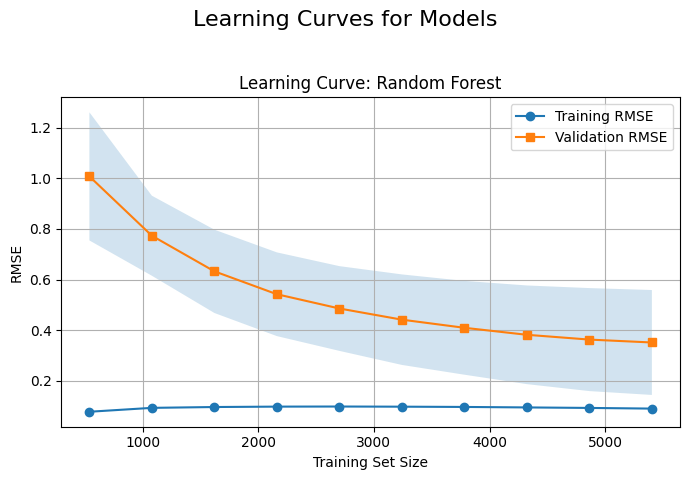

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor

# Define your model(s)
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Set up the plot
plt.figure(figsize=(7 * len(models), 5))

# Generate learning curves
for i, (name, model) in enumerate(models.items(), 1):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5,
        scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )

    train_rmse = np.sqrt(-train_scores)
    test_rmse = np.sqrt(-test_scores)

    plt.subplot(1, len(models), i)
    plt.plot(train_sizes, train_rmse.mean(axis=1), label='Training RMSE', marker='o')
    plt.plot(train_sizes, test_rmse.mean(axis=1), label='Validation RMSE', marker='s')
    plt.fill_between(train_sizes,
                     test_rmse.mean(axis=1) - test_rmse.std(axis=1),
                     test_rmse.mean(axis=1) + test_rmse.std(axis=1),
                     alpha=0.2)
    plt.title(f"Learning Curve: {name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)

plt.suptitle("Learning Curves for Models", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
